# Initializing package installation and environment variables

In [ ]:
pip install jupyterlab torch torch-geometric tensorboard torch_geometric neo4j biopython "ray[tune]" optuna

In [ ]:
pip install -U scikit-learn matplotlib

In [ ]:
pip install -U ipywidgets

In [ ]:
!nvidia-smi

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

# Creating graph dataset and integrating expression

In [2]:
from textwrap import fill
from torch_geometric.data import Data, Dataset, Batch
from torch_geometric.utils import add_self_loops
from typing import List
import torch
import os
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler


class PathwaySample:
      def __init__(self, graphs: List[Data], label: torch.Tensor, metadata=None):
          self.graphs = graphs  # List[torch_geometric.data.Data]
          self.label = label    # torch.Tensor or scalar
          self.metadata = metadata or {}

      def __len__(self):
          return len(self.graphs)

      def num_nodes_total(self):
          return sum([g.num_nodes for g in self.graphs])

      def __repr__(self):
          return f"<Sample with {len(self)} graphs | Label: {self.label}>"

class PathwayGraphDataset(Dataset):
    def __init__(self, samples: List[PathwaySample]):
        self.samples = samples
        self.labels = [s.label for s in samples]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.samples[idx]
        return sample

def collate_fn(samples: List[PathwaySample]):
    P = len(samples[0].graphs)
    labels = torch.stack([s.label for s in samples])

    pathway_batches = []
    for p in range(P):
        graphs_p = [sample.graphs[p] for sample in samples]
        batched_p = Batch.from_data_list(graphs_p)
        pathway_batches.append(batched_p)

    return pathway_batches, labels



def EntrezCaller(EntrezIds):
  from Bio import Entrez

  Entrez.email = os.getenv('email')  # NCBI requires this

  # Join IDs into a comma-separated string
  id_str = ','.join(EntrezIds)

  # Fetch summaries in batch
  handle = Entrez.esummary(db="gene", id=id_str)
  records = Entrez.read(handle)

  # Extract symbols
  symbols = [doc['Name'] for doc in records['DocumentSummarySet']['DocumentSummary']]
  return symbols

class DatasetCreate:

  def __init__(self, pathway_templates: List[Data], code_templates, expression_data, group_data):
    self.pathway_templates = pathway_templates
    self.codeToPathway, self.pathwayToCode, self.codeToGene, self.geneToCode = code_templates
    self.group_data = group_data

    self.raw_expression = self.process_genes(expression_data)
    self.expression_data = self.standardize(self.raw_expression)

  def standardize(self, df):
    scaler = StandardScaler()
    X_z = scaler.fit_transform(df.values)
    df_z = pd.DataFrame(X_z, index=df.index, columns=df.columns)
    return df_z


  def process_genes(self, expression_data):
    gene_names = expression_data.index.str.split("|").str[0]
    duplicated_mask = gene_names.duplicated(keep=False)
    duplicated_indices = expression_data.index[duplicated_mask]

    entrez_ids = duplicated_indices.str.split("|").str[1]
    symbols = EntrezCaller(entrez_ids)  # Must return a list/Series of same length as entrez_ids

    # Create new names for the duplicated indices
    new_names = [f"{symbols[i]}|{entrez_ids[i]}" for i in range(len(entrez_ids))]

    # Convert index to a Series so we can modify it
    index_series = expression_data.index.to_series()
    index_series[duplicated_mask] = new_names

    # Set the updated index
    expression_data.index = index_series.str.split("|").str[0]

    return expression_data

  def create_dataset(self):
    def progress_check(pathway_count, sample_count, tot_samples, group):
      print(f'Pathway {pathway_count}: Sample {sample_count} of {tot_samples} in group {group}')

    def get_label_subsets(expression_df, group_labels):
      """
      Groups expression data by the label in group_labels['x']
      Returns a dict mapping label -> expression subset.
      """
      label_subsets = {}
      for idx, label in enumerate(sorted(group_labels['x'].unique())):
        indices = group_labels[group_labels['x'] == label].index
        subset = expression_df.loc[:,indices]
        label_subsets[idx] = subset
      return label_subsets

    def create_filled_df(gene_names, subset_df):
      """
      Returns a DataFrame with all genes in gene_names, filled with 0.0 where missing.
      Meant to be used per label subset per pathway.
      """
      filled_df = pd.DataFrame(0.0, index=gene_names, columns=subset_df.columns)
      filled_df.update(subset_df)
      return filled_df

    def build_sample_graphs(pathway_template, filled_df, label, pathway_counter, label_name):
      import copy
      """
      Builds a list of copied pathway graphs with expression data incorporated.
      """
      sample_graphs = []
      for idx, sample in enumerate(filled_df.columns):
        if pathway_counter % 20 ==0 and idx % 50 == 0:
          progress_check(pathway_counter, idx+1, len(filled_df.columns), label_name)

        graph = copy.deepcopy(pathway_template)
        graph.x = torch.from_numpy(filled_df[sample].to_numpy(dtype='float32')).reshape(-1, 1)
        num_nodes = len(graph.gene_ids)
        if graph.edge_index.numel()==0:
          graph.edge_index, _ = add_self_loops(graph.edge_index, num_nodes=num_nodes)

        graph.edge_index, _ = add_self_loops(graph.edge_index, num_nodes=num_nodes)
        sample_graphs.append(graph)
      return sample_graphs

    def incorporate_expression(pathway_graph_templates, expression_df, group_labels):
      """
      Integrates expression data into pathway templates for multiple labels dynamically.
      """
      label_subsets = get_label_subsets(expression_df, group_labels)
      label_tensors = {label: torch.tensor(i, dtype=torch.long) for i, label in enumerate(sorted(label_subsets))}

      # Hold samples per label
      label_samples = {label: [[] for _ in range(subset.shape[1])] for label, subset in label_subsets.items()}
      # Iterate through pathways
      for pathway_counter, pathway_template in enumerate(pathway_graph_templates, start=1):
        # Get genes within pathway
        pathway_gene_codes = pathway_template.gene_ids.tolist()
        gene_names = [self.codeToGene[code] for code in pathway_gene_codes]
        # Iterate through all unique label subsets per pathway
        # builds across all samples in group graphs, returns a list of Data objects
        # store each graph to its label and sample
        for label, subset_df in label_subsets.items():
          filled_df = create_filled_df(gene_names, subset_df)
          sample_graphs = build_sample_graphs(pathway_template, filled_df, label_tensors[label], pathway_counter, f'label_{label}')
          for idx, graph in enumerate(sample_graphs):
            label_samples[label][idx].append(graph)

      def build_samples(graphs_list, label_tensor):
        return [PathwaySample(graphs, label_tensor) for graphs in graphs_list]

      # Combine all samples across all labels
      all_samples = []
      for label, samples_list in label_samples.items():
        all_samples.extend(build_samples(samples_list, label_tensors[label]))

      return all_samples


    allSamples = incorporate_expression(self.pathway_templates, self.expression_data, self.group_data)
    dataset = PathwayGraphDataset(allSamples)
      
    return dataset

In [3]:
from torch_geometric.utils import degree
from neo4j import GraphDatabase
from collections import defaultdict
import os
import matplotlib.pyplot as plt
import torch
from typing import List
from collections import defaultdict
import random


class PathwayMetaData:
  def __init__(self, pathway_templates: List[Data], code_templates):
    self.pathway_templates = pathway_templates
    self.codeToPathway, self.pathwayToCode, self.codeToGene, self.geneToCode = code_templates
    self.meta_edge_index = self.findMetaEdges()
    self.edge_weights = None
    self.norm_edge_weights = None

  def findMetaEdges(self):      
    findMetaEdges = """
    MATCH (p1:Pathway)<-[:belongs_to]-(n:Genes)-[:belongs_to]->(p2:Pathway)
    WHERE p1.name <> p2.name
    RETURN p1.name as source, p2.name as target
    """
    URI = os.getenv('neo4j_uri')
    AUTH = (os.getenv('user'), os.getenv('password'))

    driver = GraphDatabase.driver(URI, auth=AUTH)
    driver.verify_connectivity()

    meta_edge_index = driver.execute_query(findMetaEdges)
    return meta_edge_index

  def scatter_edge_weights_comparison(self, edge_weights, normalized_edge_weights):
    """
    Scatter plot of raw vs normalized edge weights by edge index.

    Args:
        edge_weights (torch.Tensor or np.array): Original edge weights.
        normalized_edge_weights (torch.Tensor or np.array): Normalized edge weights.
    """
    edge_weights = edge_weights.cpu().detach().numpy()
    normalized_edge_weights = normalized_edge_weights.cpu().detach().numpy()
    indices = range(len(edge_weights))

    plt.figure(figsize=(14, 6))

    # Raw weights scatter
    plt.subplot(1, 2, 1)
    plt.scatter(indices, edge_weights, alpha=0.6, color='blue', label='Raw weights')
    plt.title('Raw Edge Weights')
    plt.xlabel('Edge index')
    plt.ylabel('Weight')
    plt.grid(True)

    # Normalized weights scatter
    plt.subplot(1, 2, 2)
    plt.scatter(indices, normalized_edge_weights, alpha=0.6, color='green', label='Normalized weights')
    plt.title('Normalized Edge Weights')
    plt.xlabel('Edge index')
    plt.ylabel('Weight')
    plt.grid(True)

    plt.tight_layout()
    plt.show()


  def create_meta_data(self):
    records, _, _ = self.meta_edge_index

    edge_count = defaultdict(int)

    for record in records:
      source = record["source"]
      target = record["target"]

      s_code = self.pathwayToCode[source]
      p_code = self.pathwayToCode[target]

      edge = (s_code, p_code)
      edge_count[edge] += 1

    # Unzip keys and values
    pcode_list = list(edge_count.keys())
    edge_weights_list = list(edge_count.values())

    self.meta_edge_index = torch.tensor(pcode_list, dtype=torch.long).t().contiguous()
    self.edge_weights = torch.tensor(edge_weights_list, dtype=torch.long)
    def normalize_edge_weights(edge_index, edge_weight, num_nodes):
        # Calculate degree (sum of edge weights per node)
        row, col = edge_index
        deg = degree(row, num_nodes, dtype=edge_weight.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0

        # Symmetric normalization: D^{-1/2} * A * D^{-1/2}
        return deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

    self.norm_edge_weights = normalize_edge_weights(self.meta_edge_index, self.edge_weights, num_nodes=len(self.pathway_templates))

    return self.meta_edge_index, self.edge_weights, self.norm_edge_weights





In [4]:
import pandas as pd

pathway_graphs = torch.load('./drive-download/pathway_graphs.pt', weights_only=False)
code_templates = torch.load('./drive-download/code_dicts.pth', weights_only=False)
df_ductal =pd.read_csv('./drive-download/ductalAge_processed.tsv', sep='\t', index_col=0)
df_ductalGroup = pd.read_csv('./drive-download/ductalAgeGroup_processed.tsv', sep='\t', index_col=0)

In [6]:
print(len(pathway_graphs), len(code_templates[0]), len(code_templates[1]), len(code_templates[2]), len(code_templates[3]))

372 372 372 5601 5601


In [7]:
dc = DatasetCreate(pathway_graphs, code_templates, df_ductal, df_ductalGroup)

In [8]:
dataset = dc.create_dataset()

Pathway 20: Sample 1 of 240 in group label_0
Pathway 20: Sample 51 of 240 in group label_0
Pathway 20: Sample 101 of 240 in group label_0
Pathway 20: Sample 151 of 240 in group label_0
Pathway 20: Sample 201 of 240 in group label_0
Pathway 20: Sample 1 of 91 in group label_1
Pathway 20: Sample 51 of 91 in group label_1
Pathway 40: Sample 1 of 240 in group label_0
Pathway 40: Sample 51 of 240 in group label_0
Pathway 40: Sample 101 of 240 in group label_0
Pathway 40: Sample 151 of 240 in group label_0
Pathway 40: Sample 201 of 240 in group label_0
Pathway 40: Sample 1 of 91 in group label_1
Pathway 40: Sample 51 of 91 in group label_1
Pathway 60: Sample 1 of 240 in group label_0
Pathway 60: Sample 51 of 240 in group label_0
Pathway 60: Sample 101 of 240 in group label_0
Pathway 60: Sample 151 of 240 in group label_0
Pathway 60: Sample 201 of 240 in group label_0
Pathway 60: Sample 1 of 91 in group label_1
Pathway 60: Sample 51 of 91 in group label_1
Pathway 80: Sample 1 of 240 in group 

In [9]:
me_create = PathwayMetaData(pathway_graphs, code_templates)

In [10]:
meta_edge_index, edge_weights, norm_edge_weights = me_create.create_meta_data()

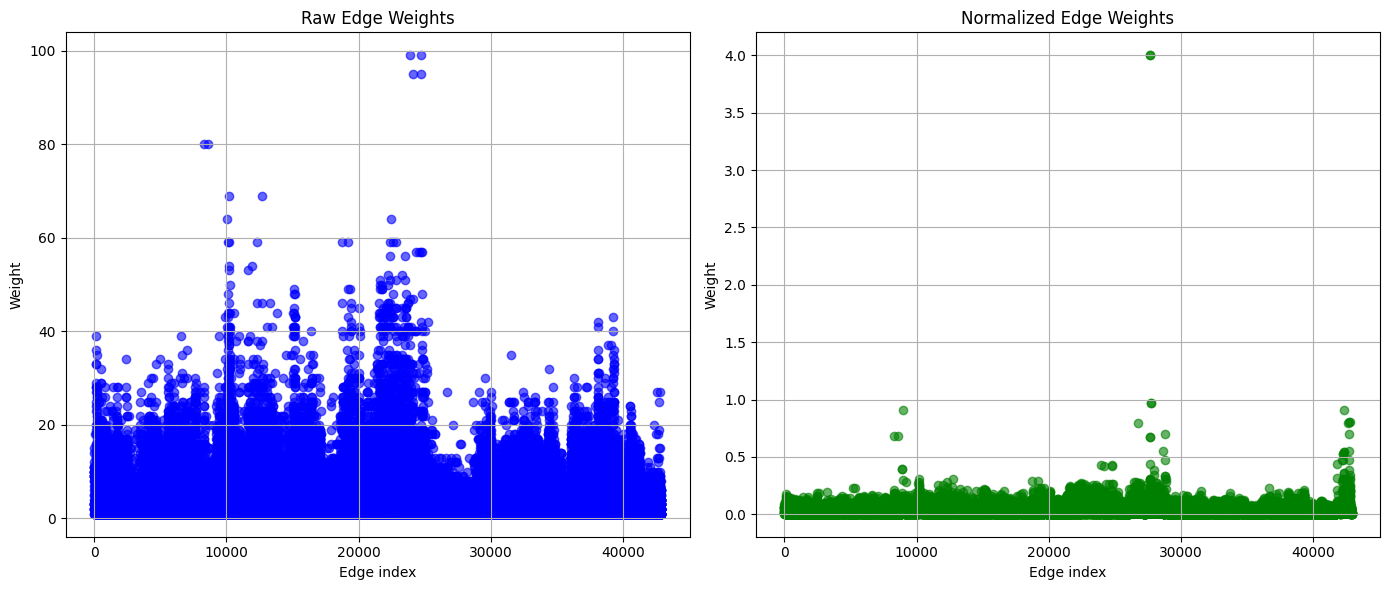

In [11]:
me_create.scatter_edge_weights_comparison(edge_weights, norm_edge_weights)

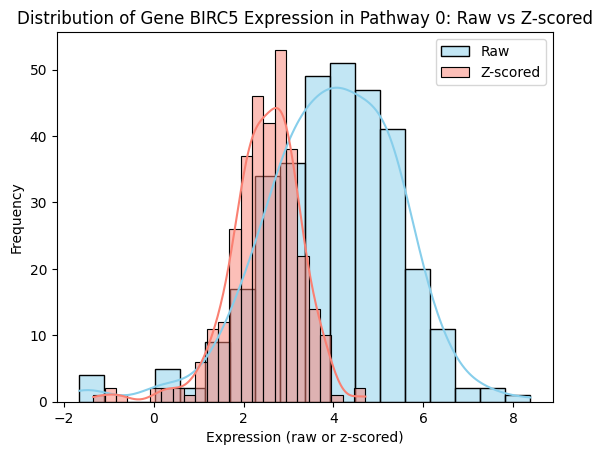

In [12]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt

# Collect gene 1 expression values across all samples' first graph
gene_ids = 1  # change this to select other genes
values = []

for sample in dataset.samples:
    x = sample.graphs[0].x  # First pathway graph
    if x is not None and x.size(0) > gene_ids:
        values.extend(x[gene_ids].cpu().numpy())  # All nodes' gene_index

gene_name = dc.codeToGene[gene_ids]

sns.histplot(dc.raw_expression.loc[gene_name], kde=True, label="Raw", color="skyblue")

# Plot
sns.histplot(values, kde=True, label="Z-scored", color="salmon")
plt.title(f"Distribution of Gene {gene_name} Expression in Pathway 0: Raw vs Z-scored")
plt.xlabel("Expression (raw or z-scored)")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Graph Statistics
We should probably take a look at the pathway graph population, we are dealing with 370 graphs per sample, and we need to get a good estimate on the number of nodes in these graphs to figure out what the optimal embedding size and layer dimensions.

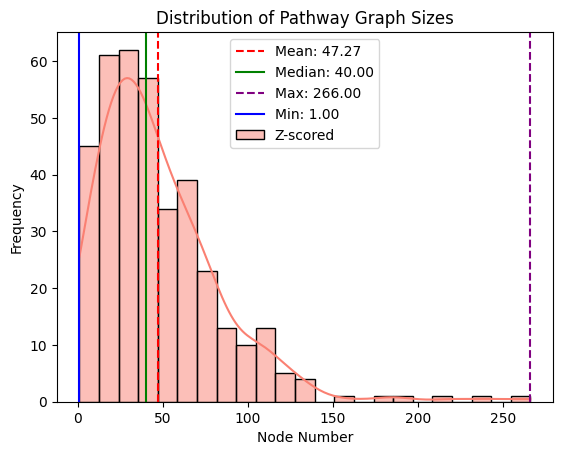

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

x_sample = dataset[0]
node_distribution = [graph.gene_ids.shape[0] for graph in x_sample.graphs]


sns.histplot(node_distribution, kde=True, label="Z-scored", color="salmon")

# Compute mean and median
mean = np.mean(node_distribution)
median = np.median(node_distribution)
max_graph = np.max(node_distribution)
min_graph = np.min(node_distribution)

# Plot vertical lines
plt.axvline(mean, color='red', linestyle='--', label=f'Mean: {mean:.2f}')
plt.axvline(median, color='green', linestyle='-', label=f'Median: {median:.2f}')
plt.axvline(max_graph, color='purple', linestyle='--', label=f'Max: {max_graph:.2f}')
plt.axvline(min_graph, color='blue', linestyle='-', label=f'Min: {min_graph:.2f}')

plt.title(f"Distribution of Pathway Graph Sizes")
plt.xlabel("Node Number")
plt.ylabel("Frequency")
plt.legend()
plt.show()

### We can delete non-informative graphs <5 nodes, this should help reduce noise.

In [14]:
print(meta_edge_index.shape, norm_edge_weights.shape)

torch.Size([2, 42890]) torch.Size([42890])


In [15]:
def sample_filter(dataset, meta_edge_index, norm_edge_weights):

    x_sample = dataset[0]
    node_distribution = [graph.gene_ids.shape[0] for graph in x_sample.graphs]
    node_distribution = np.array(node_distribution)
    indices = np.where(node_distribution >= 5)[0]

    # Step 2: Create mapping: original index -> new index
    index_map = {old_idx: new_idx for new_idx, old_idx in enumerate(indices)}
    allowed = set(indices)
    
    # Step 3: Filter sample graphs
    samples_filtered = []
    for sample in dataset.samples:
        graphs_ = [ sample.graphs[i] for i in indices]
        samples_filtered.append(PathwaySample(graphs_, sample.label))    
    filtered_dataset = PathwayGraphDataset(samples_filtered)

    src, dst = meta_edge_index
    mask = torch.tensor([(s.item() in allowed and d.item() in allowed) for s, d in zip(src, dst)])
    filtered_edge_index = meta_edge_index[:, mask]

    # Remap using index_map
    remapped_src = torch.tensor([index_map[s.item()] for s in filtered_edge_index[0]])
    remapped_dst = torch.tensor([index_map[d.item()] for d in filtered_edge_index[1]])
    remapped_edge_index = torch.stack([remapped_src, remapped_dst], dim=0)
    
    filtered_norm_edge_weights = norm_edge_weights[mask]
    
    return filtered_dataset, remapped_edge_index, filtered_norm_edge_weights, index_map


dataset, meta_edge_index, norm_edge_weights, index_map = sample_filter(dataset, meta_edge_index, norm_edge_weights)

In [16]:
print(dataset, meta_edge_index.shape, norm_edge_weights.shape)

PathwayGraphDataset(331) torch.Size([2, 42654]) torch.Size([42654])


In [17]:
max(meta_edge_index[0])

tensor(347)

In [18]:
dataset.samples[0]

<Sample with 348 graphs | Label: 0>

In [19]:
node_distribution = np.array(node_distribution)
indices = np.where(node_distribution >= 5)[0]

#Check
print(len(set(meta_edge_index[0].tolist())), len(dataset.samples[0].graphs))
print(len(indices))

348 348
348


In [20]:
from sklearn.model_selection import StratifiedShuffleSplit
from torch.utils.data import Subset

# Assume `dataset` is a PyTorch Dataset object
# and `labels` is a list or tensor of corresponding labels
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_idx, test_idx in sss.split(X=np.zeros(len(dataset.samples)), y=dataset.labels):
    train_samples = [dataset.samples[i] for i in train_idx]
    test_samples = [dataset.samples[i] for i in test_idx]

    train_dataset = PathwayGraphDataset(train_samples)
    test_dataset = PathwayGraphDataset(test_samples)



In [37]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, AttentionalAggregation

# --- Model Definitions ---
class PathwayGAT(nn.Module):
    """
    Encodes a single pathway graph per sample, with learnable attention pooling
    """
    def __init__(self, in_channels, hidden_channels, out_channels, heads=3, dropout=0.2):
        super().__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, heads=heads)
        self.norm1 = nn.LayerNorm(hidden_channels * heads)
        self.dropout = nn.Dropout(dropout)
        
        self.gat2 = GATConv(hidden_channels * heads, out_channels, heads=1)
        self.norm2 = nn.LayerNorm(out_channels)
        # Gate network for node-level attention scores
        self.attn_pool = AttentionalAggregation(
            gate_nn=nn.Sequential(
                nn.Linear(out_channels, 1),
                nn.Sigmoid()
            )
        )

    def forward(self, x, edge_index, batch):
        x = self.gat1(x, edge_index)  # → shape: [N, hidden_channels * heads]
        x = F.relu(self.norm1(x))
        x = self.dropout(x)
        x = self.gat2(x, edge_index) # → shape: [N, out_channels] for every node in the graph generate an embedding of size out_ch
        x = self.norm2(x)
        return self.attn_pool(x, batch) # → pooled graph-level output. Learn scalar per node embedding to weight


class MetaPathwayGNN(nn.Module):
    def __init__(self, pathway_dim, hidden_dim):
        super().__init__()
        self.gcn = GCNConv(pathway_dim, hidden_dim)
        self.readout = nn.Linear(hidden_dim, pathway_dim)

    def forward(self, pathway_embs, meta_edge_index, edge_weights):
        x = self.gcn(pathway_embs, meta_edge_index, edge_weights)
        return self.readout(x)


class GlobalAggregatorWithAttention(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, out_dim, dropout=0.2):
        super().__init__()
        self.attn = nn.Linear(embedding_dim, 1)  # no sigmoid
        self.fc = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.BatchNorm1d(hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, out_dim)
        )

    def forward(self, x):  # x: [B, 372, D]
        attn_weights = self.attn(x)  # [B, 372, 1]
        attn_weights = F.softmax(attn_weights, dim=1)  # softmax over pathways
        x = (x * attn_weights).sum(dim=1)  # weighted sum → [B, D]
        return self.fc(x), x



class TwoStageModelWithMetaGraph(nn.Module):
    def __init__(self, in_channels, hidden_channels, gat_out_channels,
                 agg_hidden_dim, final_out_dim, meta_hidden_dim,
                 meta_edge_index, meta_edge_weights, lambda_graph=0.1):
        super().__init__()
        self.pathway_encoder = PathwayGAT(in_channels, hidden_channels, gat_out_channels)
        self.aggregator = GlobalAggregatorWithAttention(gat_out_channels, agg_hidden_dim, final_out_dim)
        self.meta_gnn = MetaPathwayGNN(gat_out_channels, meta_hidden_dim)
        self.meta_edge_index = meta_edge_index  # KEGG pathway meta-graph edges
        self.meta_edge_weights = meta_edge_weights  # KEGG pathway meta-graph edge weights
        self.lambda_graph = lambda_graph

    def forward_batched(self, batched_embeddings, edge_index, edge_weights):
        """
        batched_embeddings: [B, P, D]
        edge_index: [2, E] on 372 nodes
        edge_weights: [E]
        """
        batch_size, num_pathways, dim = batched_embeddings.size()
        device = batched_embeddings.device
    
        all_pathways = batched_embeddings.view(-1, dim)  # [B*P, D]
    
        # Repeat and offset edge indices
        edge_index_expanded = []
        edge_weights_expanded = []
        for i in range(batch_size):
            offset = i * num_pathways
            shifted = edge_index + offset
            edge_index_expanded.append(shifted)
            edge_weights_expanded.append(edge_weights)
    
        meta_edge_index_batched = torch.cat(edge_index_expanded, dim=1).to(device)
        meta_edge_weights_batched = torch.cat(edge_weights_expanded).to(device)
    
        # GCN forward
        out = self.meta_gnn(all_pathways, meta_edge_index_batched, meta_edge_weights_batched)
        return out.view(batch_size, num_pathways, -1)


    def forward(self, pathway_graphs_list, labels=None):
        # Encode each pathway graph independently
        embeddings = []
        for idx, p_across in enumerate(pathway_graphs_list):
            h = self.pathway_encoder(p_across.x, p_across.edge_index, p_across.batch)
            embeddings.append(h)
        # Stack to shape [batch_size, num_pathways, gat_out_channels]
        stacked = torch.stack(embeddings, dim=1)
        
        # Apply MetaPathwayGNN on each sample's pathway embeddings
        # Meta-graph GCN expects [num_pathways, pathway_dim], so we loop batch-wise
        enhanced_embeddings = self.forward_batched(stacked, self.meta_edge_index, self.meta_edge_weights)

        # Aggregate to final output
        out, pooled_embedding = self.aggregator(enhanced_embeddings)
        # Compute graph smoothness regularizer if labels provided (training mode)
        batch_size = enhanced_embeddings.size(0)
        reg_loss = 0
        if labels is not None:
            src, dst = self.meta_edge_index
            for i in range(batch_size):
                pathway_emb = enhanced_embeddings[i]
                reg_loss += F.mse_loss(pathway_emb[src], pathway_emb[dst])

            reg_loss = self.lambda_graph * reg_loss / batch_size

        return out, reg_loss, pooled_embedding

In [41]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from torch.utils.tensorboard import SummaryWriter
from collections import Counter

def log_gradients(model, writer, epoch, log_every=1, group_by_module=True):
    """
    Logs gradient histograms and norms for each parameter and the total gradient norm.

    Args:
        model (nn.Module): The model with gradients to log.
        writer (SummaryWriter): TensorBoard writer instance.
        epoch (int): Current epoch number.
        log_every (int): Log only every `log_every` epochs.
        group_by_module (bool): Group histogram tags by top-level module name.
    """
    if epoch % log_every != 0:
        return

    total_grad_norm_sq = 0.0
    for name, param in model.named_parameters():
        if param.grad is None:
            continue
        grad = param.grad.data
        param_norm = grad.norm(2)
        total_grad_norm_sq += param_norm.item() ** 2
        # Optional: group by module name
        if group_by_module:
            tag = f"{name.split('.')[0]}/{name}"
        else:
            tag = name
        # Log histogram of gradients
        writer.add_histogram(f"gradients/{tag}", grad, global_step=epoch)
        # Log scalar gradient norm for each parameter
        writer.add_scalar(f"grad_norms/{tag}", param_norm.item(), global_step=epoch)

    # Log total gradient norm (global L2 norm)
    total_grad_norm = total_grad_norm_sq ** 0.5
    writer.add_scalar("gradients/total_grad_norm", total_grad_norm, global_step=epoch)


def log_embeddings_to_tensorboard(embedding_tensor, labels, epoch, log_every=2):
    """
    embedding_tensor: [N, D] torch.Tensor
    labels: [N] tensor of int or float
    """
    if epoch % log_every != 0:
        return
        
    writer.add_embedding(embedding_tensor, metadata=labels.tolist(), global_step=epoch, tag="aggregator_embeddings")


# --- Training Loop ---
def model_train(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    total_reg_loss = 0
    # class_distribution(loader)
    for pathways_batched, labels in loader:
        labels = labels.to(device).float()
        pathways_batched = [pathway.to(device) for pathway in pathways_batched]
        logits, reg_loss, _ = model(pathways_batched, labels)
        loss = criterion(logits.squeeze(), labels) + reg_loss
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients to prevent explosion
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        log_gradients(model, writer, epoch, log_every=1)
        optimizer.step()
        total_loss += loss.item() * labels.size(0)
        total_reg_loss += reg_loss.item() * labels.size(0)  # <-- Track reg_loss

    avg_loss = total_loss / len(loader.dataset)
    avg_reg = total_reg_loss / len(loader.dataset)
    print(f"Train Loss: {avg_loss:.4f} | Reg Loss: {avg_reg:.4f}")  # Optional logging
    return avg_loss

# For gene ranking/interpretability
def evaluate_gene_importance(model, loader, device):
    model.eval()
    gene_scores = []  # list of (gene_id, score)
    with torch.no_grad():
        for graphs_list, _ in loader:
            for data in graphs_list:
                x = data.x.to(device)
                edge_index = data.edge_index.to(device)
                batch = data.batch.to(device)

                x = F.relu(model.pathway_encoder.gat1(x, edge_index))
                node_embeddings = model.pathway_encoder.gat2(x, edge_index)

                # Compute gate scores using node embeddings
                scores = model.pathway_encoder.attn_pool.gate_nn(node_embeddings).squeeze()

                # collect gene_ids
                ids = data.gene_ids
                for gid, sc in zip(ids.tolist(), scores.tolist()):
                    gene_scores.append((gid, sc))

    # aggregate by gene ID
    import pandas as pd
    df = pd.DataFrame(gene_scores, columns=['gene_id', 'score'])
    agg = df.groupby('gene_id')['score'].mean().reset_index()
    return agg.sort_values('score', ascending=False)


def model_evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    all_embeddings = []
    # class_distribution(loader)

    with torch.no_grad():
        for pathways_batched, labels in loader:
            labels = labels.to(device).float()

            pathways_batched = [d.to(device) for d in pathways_batched]

            logits, _, embeddings_pooled = model(pathways_batched)
            logits = logits.squeeze()
            loss = criterion(logits, labels)
            total_loss += loss.item() * labels.size(0)

            probs = torch.sigmoid(logits)
            all_preds.append(probs.detach().cpu())
            all_labels.append(labels.detach().cpu())
            all_embeddings.append(embeddings_pooled.detach().cpu())

    # Concatenate across batches
    embeddings_tensor = torch.cat(all_embeddings).cpu().numpy()
    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    log_embeddings_to_tensorboard(embeddings_tensor, all_labels, epoch)
    
    # Compute metrics
    pred_binary = (all_preds > 0.5).astype(int)
    acc = accuracy_score(all_labels, pred_binary)
    f1 = f1_score(all_labels, pred_binary)

    try:
        auc = roc_auc_score(all_labels, all_preds)
    except ValueError:
        auc = float('nan')  # In case only one class is present

    avg_loss = total_loss / len(loader.dataset)
    return avg_loss, auc, f1, all_preds, all_labels


In [39]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

def calculate_confidence(all_preds, all_labels):
    conf_pos = (all_preds[all_labels == 1] - 0.5)/0.5
    conf_neg = (0.5 - all_preds[all_labels == 0])/0.5
    conf_pos = np.maximum(conf_pos, 0)
    conf_neg = np.maximum(conf_neg, 0)
    mean_conf_pos = np.mean(conf_pos)
    mean_conf_neg = np.mean(conf_neg)

    return mean_conf_pos, mean_conf_neg, conf_pos, conf_neg

def plot_scores(scores, confidence, model):
    """
    Plots the F1 scores for training and validation data.

    Parameters:
        scores (list of lists): A list containing two lists:
            - The first list contains the training scores for each epoch.
            - The second list contains the validation scores for each epoch.
    """
    # Unpack the scores
    training_scores, validation_scores = scores
    pos_conf, neg_conf = confidence

    # Generate a color for the plot based on the fold number
    colors = plt.cm.tab10.colors
    color = colors[fold % len(colors)]

    # # Clear the current plot only
    axs[0].clear()
    axs[1].clear()

    # Create the plot
    axs[0].plot(training_scores, label='Training Score', color=color)
    axs[0].plot(validation_scores, label='Validation Score', color=color, linestyle='--')
    axs[0].set_xlabel('Epochs')
    axs[0].set_ylabel('F1 Score')
    axs[0].set_title('F1 Scores', fontsize=5)
    axs[0].legend()
    axs[0].grid(True)

    # Plot 2: Confidence Scores
    axs[1].plot(pos_conf, label = 'Positive Confidence', color = color)
    axs[1].plot(neg_conf, label = 'Negative Confidence', color = color, linestyle='--')
    axs[1].set_title('Median Confidence')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Confidence (0-1)')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    # Display the plot
    display(fig)
    clear_output(wait=True)

In [24]:
print(len(train_dataset.samples))
print(type(train_dataset.samples))

264
<class 'list'>


In [25]:
train_graphs = [sample.graphs for sample in train_dataset.samples]
train_labels = train_dataset.labels
print(len(train_graphs[0]))
print(train_labels[0])

348
tensor(0)


#--------------------------Visualizing model performance---------------------------------------------------------------

We will first start by checking if the model is accurately able to create and update pathway embeddings.
Remember these embeddings are updated by backpropogation due to global-level results from training.
So we can visualize model performance while tracking embedding resolution using PCA plots, and figuring out if the decision boundary is improving.

In [26]:
def balance_dataset(dataset):
    """
    Duplicates samples from the minority class to match the size of the majority class.
    
    Parameters:
    - dataset: your custom dataset (must have `.samples` or similar)
    
    Returns:
    - A balanced dataset with equal number of samples from both classes.
    """
    class_to_samples = defaultdict(list)
    
    # Group samples by class label
    for sample, label in zip(dataset.samples, dataset.labels):
        class_to_samples[label].append((sample, label))
    
    # Identify majority and minority
    class_sizes = {k: len(v) for k, v in class_to_samples.items()}
    majority_class = max(class_sizes, key=class_sizes.get)
    minority_class = min(class_sizes, key=class_sizes.get)
    
    majority_samples = class_to_samples[majority_class]
    minority_samples = class_to_samples[minority_class]
    
    num_to_add = len(majority_samples) - len(minority_samples)
    duplicated = random.choices(minority_samples, k=num_to_add)
    balanced_samples = majority_samples + minority_samples + duplicated
    
    # Shuffle to mix classes
    random.shuffle(balanced_samples)
    # Unzip back into samples and labels
    samples, labels = zip(*balanced_samples)
    
    #You may need to reconstruct your dataset depending on your classes
    dataset.samples = list(samples)
    dataset.labels = list(labels)
  
    return dataset

# No Attentional Aggregation

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter
from torch.utils.tensorboard import SummaryWriter


if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 64
  out_ch = [64]
  agg_hid = 32
  final_out = 1
  lr = 1e-3
  epochs = 100
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 8
  grace_period = 15
  best_val_f1 = -np.inf

  # Figure for plotting in real-time
  fig, axs = plt.subplots(1, 2, figsize=(12, 4)) # Two plots side by side
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []
  valid_conf_pos = []
  valid_conf_neg = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      for out_channel in out_ch:
          writer = SummaryWriter(log_dir=f"runs/gradient_debugging5_{out_channel}")
          min_val_f1 = -np.inf
          epochs_no_improve = 0
          #Instantiate model, optimizer, criterion
          model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                              hidden_channels = hid_ch,
                                              gat_out_channels = out_channel,
                                              agg_hidden_dim = agg_hid,
                                              final_out_dim = final_out,
                                              meta_edge_index = meta_edge_index,
                                              meta_edge_weights = norm_edge_weights,
                                              meta_hidden_dim=meta_hidden_dim)
          model = model.to(device)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=3)
    
          # Split into training and testing data sets
          fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
          fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])
          print(fold_train_data, fold_valid_data)

          num_pos = fold_train_data.labels
          label_tensor = torch.stack(fold_train_data.labels)
          #Count 0s and 1s
          num_zeros = (label_tensor == 0).sum().item()
          num_ones = (label_tensor == 1).sum().item()
          pos_weights = torch.tensor([num_zeros / num_ones])
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
          
          train_loader = DataLoader(fold_train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
          valid_loader = DataLoader(fold_valid_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
    
          for epoch in range(1, epochs+1):
              
              avg_loss = model_train(model, train_loader, optimizer, criterion, device)
              train_avg_loss, train_roc, train_f1, _, _, = model_evaluate(model, train_loader, criterion, device)
              val_avg_loss, val_roc, val_f1, all_preds, all_labels = model_evaluate(model, valid_loader, criterion, device)
              conf_pos, conf_neg, _, _ = calculate_confidence(all_preds, all_labels)
              
              scheduler.step(val_f1)
              writer.add_scalar("f1/train", train_f1, epoch)
              writer.add_scalar("f1/val", val_f1, epoch)
    
              train_f1_scores.append(train_f1)
              valid_f1_scores.append(val_f1)
              valid_conf_pos.append(conf_pos)
              valid_conf_neg.append(conf_neg)
    
              print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
              Train F1: {train_f1}, Val F1: {val_f1}, \
              Train ROC: {train_roc}, Val ROC: {val_roc}')
    
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Current LR: {current_lr}')
    
              plot_scores([train_f1_scores, valid_f1_scores], [valid_conf_pos, valid_conf_neg], model)
              time.sleep(0.1)
    
              # # Early stopping
              # if epoch % 3 == 0:
              # Check if validation f1 increased
              if grace_period < epoch: 
                  if val_f1 > min_val_f1:
                      # If this is the best validation score yet, save model.
                      if val_f1 > best_val_f1:
                          best_val_f1 = val_f1
                          # Save the model
                          torch.save(model.state_dict(), './best_model_1.pt')
        
                      min_val_f1 = val_f1
                      epochs_no_improve = 0
                  else:
                      print('Hit no improve', epochs_no_improve)
                      epochs_no_improve += 1
                      # Check early stopping condition
                      if epochs_no_improve > n_epochs_stop:
                          # print('Early stopping!')
                          # # Load best model weights
                          # model.load_state_dict(torch.load('./best_model_1.pt'))
                          break
      break

# With Attentional Aggregation

Hit no improve 8


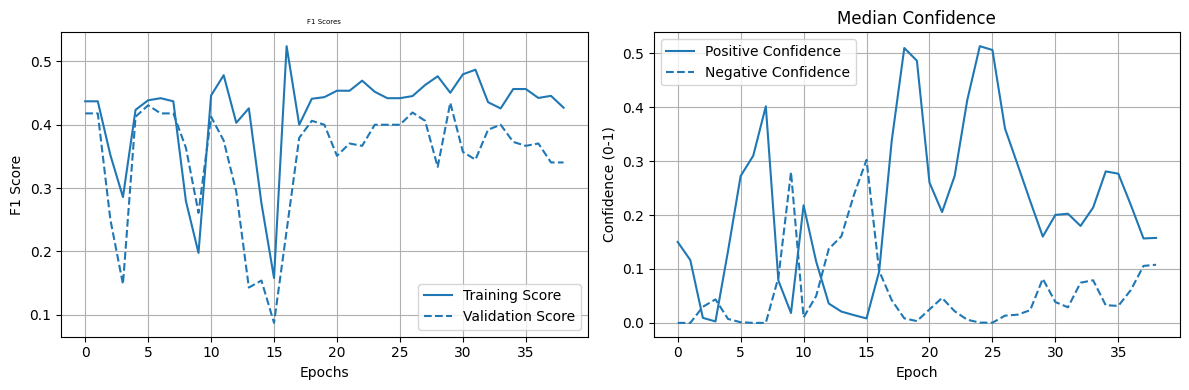

In [35]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter
from torch.utils.tensorboard import SummaryWriter


if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 32 #32 * 3 = 96 which is near the median, so that each node can meaningfully contribute but not overwhelm
  out_ch = [64] # We use smaller pathway embeddings to create general easily workable represa
  agg_hid = 32
  final_out = 1
  lr = 5e-3
  epochs = 100
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 8
  grace_period = 15
  best_val_f1 = -np.inf

  # Figure for plotting in real-time
  fig, axs = plt.subplots(1, 2, figsize=(12, 4)) # Two plots side by side
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []
  valid_conf_pos = []
  valid_conf_neg = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      for out_channel in out_ch:
          writer = SummaryWriter(log_dir=f"runs/gradient_filt2_aa_{out_channel}")
          min_val_f1 = -np.inf
          epochs_no_improve = 0
          #Instantiate model, optimizer, criterion
          model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                              hidden_channels = hid_ch,
                                              gat_out_channels = out_channel,
                                              agg_hidden_dim = agg_hid,
                                              final_out_dim = final_out,
                                              meta_edge_index = meta_edge_index,
                                              meta_edge_weights = norm_edge_weights,
                                              meta_hidden_dim=meta_hidden_dim)
          model = model.to(device)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3)
    
          # Split into training and testing data sets
          fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
          fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])
          print(fold_train_data, fold_valid_data)

          num_pos = fold_train_data.labels
          label_tensor = torch.stack(fold_train_data.labels)
          #Count 0s and 1s
          num_zeros = (label_tensor == 0).sum().item()
          num_ones = (label_tensor == 1).sum().item()
          pos_weights = torch.tensor([num_zeros / num_ones])
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
          
          train_loader = DataLoader(fold_train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
          valid_loader = DataLoader(fold_valid_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
    
          for epoch in range(1, epochs+1):
              
              avg_loss = model_train(model, train_loader, optimizer, criterion, device)
              train_avg_loss, train_roc, train_f1, _, _, = model_evaluate(model, train_loader, criterion, device)
              val_avg_loss, val_roc, val_f1, all_preds, all_labels = model_evaluate(model, valid_loader, criterion, device)
              conf_pos, conf_neg, _, _ = calculate_confidence(all_preds, all_labels)
              
              scheduler.step(val_f1)
              writer.add_scalar("f1/train", train_f1, epoch)
              writer.add_scalar("f1/val", val_f1, epoch)
    
              train_f1_scores.append(train_f1)
              valid_f1_scores.append(val_f1)
              valid_conf_pos.append(conf_pos)
              valid_conf_neg.append(conf_neg)
    
              print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
              Train F1: {train_f1}, Val F1: {val_f1}, \
              Train ROC: {train_roc}, Val ROC: {val_roc}')
    
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Current LR: {current_lr}')
    
              plot_scores([train_f1_scores, valid_f1_scores], [valid_conf_pos, valid_conf_neg], model)
              time.sleep(0.1)
    
              # # Early stopping
              # if epoch % 3 == 0:
              # Check if validation f1 increased
              if grace_period < epoch: 
                  if val_f1 > min_val_f1:
                      # If this is the best validation score yet, save model.
                      if val_f1 > best_val_f1:
                          best_val_f1 = val_f1
                          # Save the model
                          torch.save(model.state_dict(), './best_model_1.pt')
        
                      min_val_f1 = val_f1
                      epochs_no_improve = 0
                  else:
                      print('Hit no improve', epochs_no_improve)
                      epochs_no_improve += 1
                      # Check early stopping condition
                      if epochs_no_improve > n_epochs_stop:
                          # print('Early stopping!')
                          # # Load best model weights
                          # model.load_state_dict(torch.load('./best_model_1.pt'))
                          break
      break

Hit no improve 8


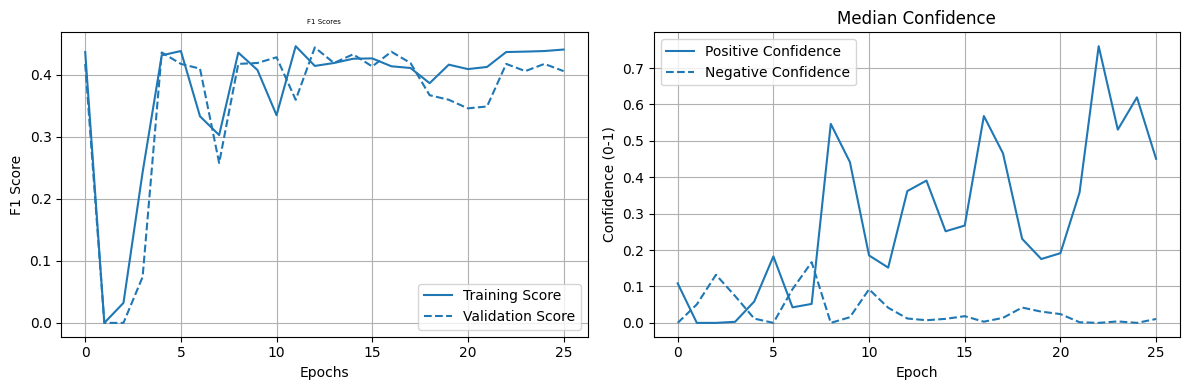

In [36]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter
from torch.utils.tensorboard import SummaryWriter


if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 64 #32 * 3 = 96 which is near the median, so that each node can meaningfully contribute but not overwhelm
  out_ch = [64] # We use smaller pathway embeddings to create general easily workable represa
  agg_hid = 32
  final_out = 1
  lr = 5e-3
  epochs = 100
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 8
  grace_period = 15
  best_val_f1 = -np.inf

  # Figure for plotting in real-time
  fig, axs = plt.subplots(1, 2, figsize=(12, 4)) # Two plots side by side
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []
  valid_conf_pos = []
  valid_conf_neg = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      for out_channel in out_ch:
          writer = SummaryWriter(log_dir=f"runs/gradient_filt2_h64_aa_{out_channel}")
          min_val_f1 = -np.inf
          epochs_no_improve = 0
          #Instantiate model, optimizer, criterion
          model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                              hidden_channels = hid_ch,
                                              gat_out_channels = out_channel,
                                              agg_hidden_dim = agg_hid,
                                              final_out_dim = final_out,
                                              meta_edge_index = meta_edge_index,
                                              meta_edge_weights = norm_edge_weights,
                                              meta_hidden_dim=meta_hidden_dim)
          model = model.to(device)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3)
    
          # Split into training and testing data sets
          fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
          fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])
          print(fold_train_data, fold_valid_data)

          num_pos = fold_train_data.labels
          label_tensor = torch.stack(fold_train_data.labels)
          #Count 0s and 1s
          num_zeros = (label_tensor == 0).sum().item()
          num_ones = (label_tensor == 1).sum().item()
          pos_weights = torch.tensor([num_zeros / num_ones])
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
          
          train_loader = DataLoader(fold_train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
          valid_loader = DataLoader(fold_valid_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
    
          for epoch in range(1, epochs+1):
              
              avg_loss = model_train(model, train_loader, optimizer, criterion, device)
              train_avg_loss, train_roc, train_f1, _, _, = model_evaluate(model, train_loader, criterion, device)
              val_avg_loss, val_roc, val_f1, all_preds, all_labels = model_evaluate(model, valid_loader, criterion, device)
              conf_pos, conf_neg, _, _ = calculate_confidence(all_preds, all_labels)
              
              scheduler.step(val_f1)
              writer.add_scalar("f1/train", train_f1, epoch)
              writer.add_scalar("f1/val", val_f1, epoch)
    
              train_f1_scores.append(train_f1)
              valid_f1_scores.append(val_f1)
              valid_conf_pos.append(conf_pos)
              valid_conf_neg.append(conf_neg)
    
              print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
              Train F1: {train_f1}, Val F1: {val_f1}, \
              Train ROC: {train_roc}, Val ROC: {val_roc}')
    
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Current LR: {current_lr}')
    
              plot_scores([train_f1_scores, valid_f1_scores], [valid_conf_pos, valid_conf_neg], model)
              time.sleep(0.1)
    
              # # Early stopping
              # if epoch % 3 == 0:
              # Check if validation f1 increased
              if grace_period < epoch: 
                  if val_f1 > min_val_f1:
                      # If this is the best validation score yet, save model.
                      if val_f1 > best_val_f1:
                          best_val_f1 = val_f1
                          # Save the model
                          torch.save(model.state_dict(), './best_model_1.pt')
        
                      min_val_f1 = val_f1
                      epochs_no_improve = 0
                  else:
                      print('Hit no improve', epochs_no_improve)
                      epochs_no_improve += 1
                      # Check early stopping condition
                      if epochs_no_improve > n_epochs_stop:
                          # print('Early stopping!')
                          # # Load best model weights
                          # model.load_state_dict(torch.load('./best_model_1.pt'))
                          break
      break

KeyboardInterrupt: 

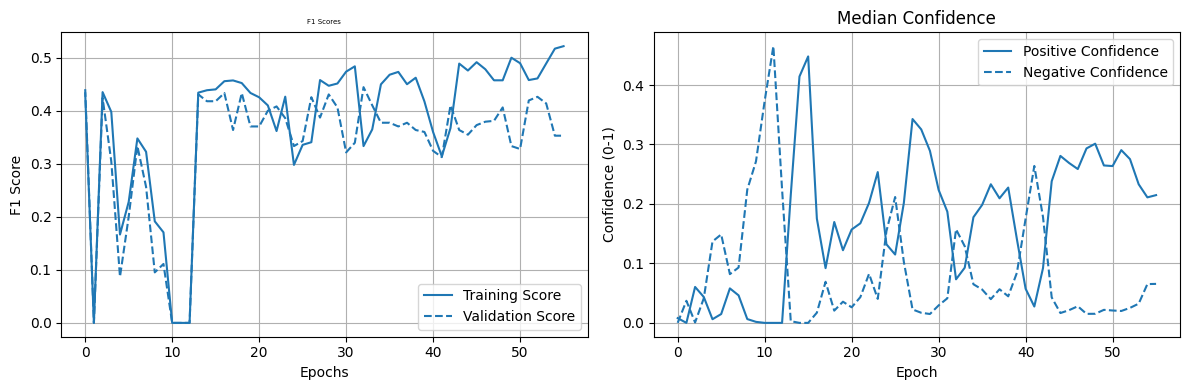

In [43]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter
from torch.utils.tensorboard import SummaryWriter


if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 64 #32 * 3 = 96 which is near the median, so that each node can meaningfully contribute but not overwhelm
  out_ch = [64] # We use smaller pathway embeddings to create general easily workable represa
  agg_hid = 32
  final_out = 1
  lr = 5e-3
  epochs = 100
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 8
  grace_period = 15
  best_val_f1 = -np.inf

  # Figure for plotting in real-time
  fig, axs = plt.subplots(1, 2, figsize=(12, 4)) # Two plots side by side
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []
  valid_conf_pos = []
  valid_conf_neg = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      for out_channel in out_ch:
          writer = SummaryWriter(log_dir=f"runs/gradient_unlEmbed_h64out64_{out_channel}")
          min_val_f1 = -np.inf
          epochs_no_improve = 0
          #Instantiate model, optimizer, criterion
          model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                              hidden_channels = hid_ch,
                                              gat_out_channels = out_channel,
                                              agg_hidden_dim = agg_hid,
                                              final_out_dim = final_out,
                                              meta_edge_index = meta_edge_index,
                                              meta_edge_weights = norm_edge_weights,
                                              meta_hidden_dim=meta_hidden_dim)
          model = model.to(device)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=4)
    
          # Split into training and testing data sets
          fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
          fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])
          print(fold_train_data, fold_valid_data)

          num_pos = fold_train_data.labels
          label_tensor = torch.stack(fold_train_data.labels)
          #Count 0s and 1s
          num_zeros = (label_tensor == 0).sum().item()
          num_ones = (label_tensor == 1).sum().item()
          pos_weights = torch.tensor([num_zeros / num_ones])
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
          
          train_loader = DataLoader(fold_train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
          valid_loader = DataLoader(fold_valid_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
    
          for epoch in range(1, epochs+1):
              
              avg_loss = model_train(model, train_loader, optimizer, criterion, device)
              train_avg_loss, train_roc, train_f1, _, _, = model_evaluate(model, train_loader, criterion, device)
              val_avg_loss, val_roc, val_f1, all_preds, all_labels = model_evaluate(model, valid_loader, criterion, device)
              conf_pos, conf_neg, _, _ = calculate_confidence(all_preds, all_labels)
              
              scheduler.step(val_f1)
              writer.add_scalar("f1/train", train_f1, epoch)
              writer.add_scalar("f1/val", val_f1, epoch)
    
              train_f1_scores.append(train_f1)
              valid_f1_scores.append(val_f1)
              valid_conf_pos.append(conf_pos)
              valid_conf_neg.append(conf_neg)
    
              print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
              Train F1: {train_f1}, Val F1: {val_f1}, \
              Train ROC: {train_roc}, Val ROC: {val_roc}')
    
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Current LR: {current_lr}')
    
              plot_scores([train_f1_scores, valid_f1_scores], [valid_conf_pos, valid_conf_neg], model)
              time.sleep(0.1)
    
              # # Early stopping
              # if epoch % 3 == 0:
              # Check if validation f1 increased
              if grace_period < epoch and val_f1 > 0.8: 
                  if val_f1 > min_val_f1:
                      # If this is the best validation score yet, save model.
                      if val_f1 > best_val_f1:
                          best_val_f1 = val_f1
                          # Save the model
                          torch.save(model.state_dict(), './best_model_1.pt')
        
                      min_val_f1 = val_f1
                      epochs_no_improve = 0
                  else:
                      print('Hit no improve', epochs_no_improve)
                      epochs_no_improve += 1
                      # Check early stopping condition
                      if epochs_no_improve > n_epochs_stop:
                          # print('Early stopping!')
                          # # Load best model weights
                          # model.load_state_dict(torch.load('./best_model_1.pt'))
                          break
      break

Train Loss: 0.7343 | Reg Loss: 0.0012
Fold 0: Epoch 23/100, Train Loss: 0.7787633574969396, Val Loss: 0.7815049290657043,               Train F1: 0.0625, Val F1: 0.0,               Train ROC: 0.5801739518287243, Val ROC: 0.5402930402930404
Current LR: 0.0012004999999999995


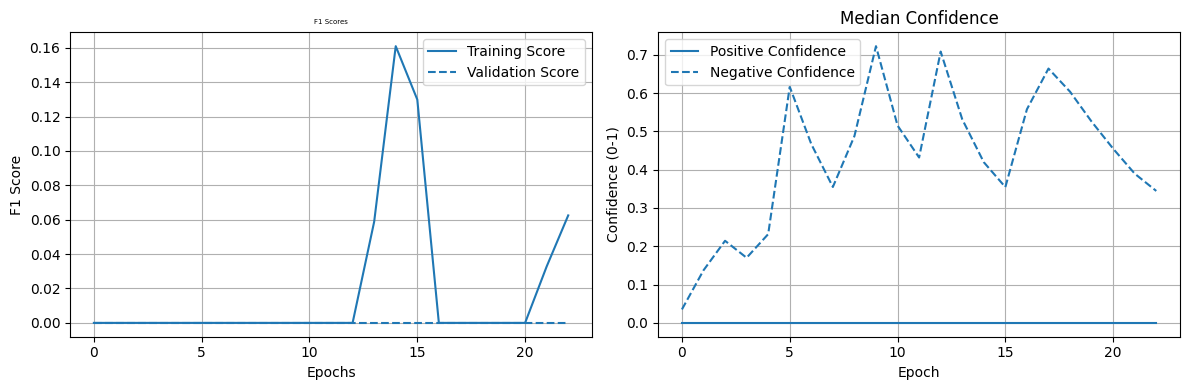

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter
from torch.utils.tensorboard import SummaryWriter


if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 64 #32 * 3 = 96 which is near the median, so that each node can meaningfully contribute but not overwhelm
  out_ch = [64] # We use smaller pathway embeddings to create general easily workable represa
  agg_hid = 32
  final_out = 1
  lr = 5e-3
  epochs = 100
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 8
  grace_period = 15
  best_val_f1 = -np.inf

  # Figure for plotting in real-time
  fig, axs = plt.subplots(1, 2, figsize=(12, 4)) # Two plots side by side
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []
  valid_conf_pos = []
  valid_conf_neg = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      for out_channel in out_ch:
          writer = SummaryWriter(log_dir=f"runs/gradient_unlPosSQRT_h64out64_{out_channel}")
          min_val_f1 = -np.inf
          epochs_no_improve = 0
          #Instantiate model, optimizer, criterion
          model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                              hidden_channels = hid_ch,
                                              gat_out_channels = out_channel,
                                              agg_hidden_dim = agg_hid,
                                              final_out_dim = final_out,
                                              meta_edge_index = meta_edge_index,
                                              meta_edge_weights = norm_edge_weights,
                                              meta_hidden_dim=meta_hidden_dim)
          model = model.to(device)
          optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
          scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=4)
    
          # Split into training and testing data sets
          fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
          fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])
          print(fold_train_data, fold_valid_data)

          num_pos = fold_train_data.labels
          label_tensor = torch.stack(fold_train_data.labels)
          #Count 0s and 1s
          num_zeros = (label_tensor == 0).sum().item()
          num_ones = (label_tensor == 1).sum().item()
          pos_weights = torch.tensor([num_zeros / num_ones]) ** 0.5
          criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)
          
          train_loader = DataLoader(fold_train_data, batch_size=64, shuffle=False, collate_fn=collate_fn)
          valid_loader = DataLoader(fold_valid_data, batch_size=64, collate_fn=collate_fn, shuffle=True)
    
          for epoch in range(1, epochs+1):
              
              avg_loss = model_train(model, train_loader, optimizer, criterion, device)
              train_avg_loss, train_roc, train_f1, _, _, = model_evaluate(model, train_loader, criterion, device)
              val_avg_loss, val_roc, val_f1, all_preds, all_labels = model_evaluate(model, valid_loader, criterion, device)
              conf_pos, conf_neg, _, _ = calculate_confidence(all_preds, all_labels)
              
              scheduler.step(val_f1)
              writer.add_scalar("f1/train", train_f1, epoch)
              writer.add_scalar("f1/val", val_f1, epoch)
    
              train_f1_scores.append(train_f1)
              valid_f1_scores.append(val_f1)
              valid_conf_pos.append(conf_pos)
              valid_conf_neg.append(conf_neg)
    
              print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
              Train F1: {train_f1}, Val F1: {val_f1}, \
              Train ROC: {train_roc}, Val ROC: {val_roc}')
    
              current_lr = optimizer.param_groups[0]['lr']
              print(f'Current LR: {current_lr}')
    
              plot_scores([train_f1_scores, valid_f1_scores], [valid_conf_pos, valid_conf_neg], model)
              time.sleep(0.1)
    
              # # Early stopping
              # if epoch % 3 == 0:
              # Check if validation f1 increased
              if grace_period < epoch and val_f1 > 0.8: 
                  if val_f1 > min_val_f1:
                      # If this is the best validation score yet, save model.
                      if val_f1 > best_val_f1:
                          best_val_f1 = val_f1
                          # Save the model
                          torch.save(model.state_dict(), './best_model_1.pt')
        
                      min_val_f1 = val_f1
                      epochs_no_improve = 0
                  else:
                      print('Hit no improve', epochs_no_improve)
                      epochs_no_improve += 1
                      # Check early stopping condition
                      if epochs_no_improve > n_epochs_stop:
                          # print('Early stopping!')
                          # # Load best model weights
                          # model.load_state_dict(torch.load('./best_model_1.pt'))
                          break
      break

In [ ]:
import ray
from ray import tune
from ray.air import session
from ray.tune.schedulers import ASHAScheduler
from ray.tune.search.optuna import OptunaSearch
from sklearn.model_selection import train_test_split


def ray_tune_train(config, data_refs=None):
    graphs_train_dataset = ray.get(data_refs["graphs_dataset_id"])
    labels_train_dataset = ray.get(data_refs["labels_dataset_id"])
    meta_edge_index = ray.get(data_refs["meta_edge_index_id"])
    norm_edge_weights = ray.get(data_refs["norm_edge_weights_id"])

    num_pathways = 372

    train_dataset = [PathwaySample(t_g, t_l) for t_g, t_l in zip(graphs_train_dataset, labels_train_dataset)]

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    val_f1_scores = []

    train_idx, valid_idx = train_test_split(
        list(range(len(train_dataset))), test_size=0.3, stratify=labels_train_dataset, random_state=42
    )
    model = TwoStageModelWithMetaGraph(
        in_channels=config["in_channels"],
        hidden_channels=config["hidden_channels"],
        gat_out_channels=config["gat_out_channels"],
        num_pathways=num_pathways,
        agg_hidden_dim=config["agg_hidden_dim"],
        final_out_dim=config["final_out_dim"],
        meta_edge_index=meta_edge_index,
        meta_edge_weights=norm_edge_weights,
        meta_hidden_dim=config["meta_hidden_dim"]
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
    criterion = nn.BCEWithLogitsLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.8, patience=5)

    fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_idx])
    fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_idx])

    train_loader = create_balanced_dataloader(fold_train_data, batch_size=24, collate_fn=collate_fn)
    valid_loader = create_balanced_dataloader(fold_valid_data, batch_size=24, collate_fn=collate_fn, shuffle=True)

    best_val_f1 = 0

    for epoch in range(1, 101):
        model_train(model, train_loader, optimizer, criterion, device)
        _, _, val_f1, _, _ = model_evaluate(model, valid_loader, criterion, device)
        scheduler.step(val_f1)
    
        best_val_f1 = max(best_val_f1, val_f1)
        current_lr = optimizer.param_groups[0]['lr']
    
        session.report({"f1": val_f1, "lr": current_lr})

    val_f1_scores.append(best_val_f1)

    return val_f1_scores

In [ ]:
short_log_dir = os.path.abspath("ray_trace_results")
short_log_dir

In [ ]:
ray.shutdown()
ray.init()

In [ ]:
train_graphs = [sample.graphs for sample in train_dataset.samples]
train_labels = train_dataset.labels
X_train_dataset_id = ray.put(train_graphs)
y_train_dataset_id = ray.put(train_labels)
meta_edge_index_id = ray.put(meta_edge_index)
norm_edge_weights_id = ray.put(norm_edge_weights)

In [ ]:
import os


search_space = {
    "in_channels": tune.choice([1]),
    "hidden_channels": tune.choice([16, 32, 64, 128]),
    "gat_out_channels": tune.choice([16, 32, 64]),
    "agg_hidden_dim": tune.choice([32, 64, 128]),
    "final_out_dim": tune.choice([1]),
    "meta_hidden_dim": tune.choice([16, 32, 64]),
}

# Wrap the data references in a dictionary
data_refs = {
    "graphs_dataset_id": X_train_dataset_id,
    "labels_dataset_id": y_train_dataset_id,
    "meta_edge_index_id": meta_edge_index_id,
    "norm_edge_weights_id": norm_edge_weights_id
}

# Pass a single parameter to avoid Ray unwrapping them
train_fn = tune.with_parameters(
    ray_tune_train,
    data_refs=data_refs
)


optuna_search = OptunaSearch(metric="f1", mode="max")
scheduler = ASHAScheduler(max_t=40, grace_period=10, reduction_factor=2, metric="f1", mode="max")

tuner = tune.Tuner(
    train_fn,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=scheduler,
        num_samples=20,
    ),
    run_config=tune.RunConfig(storage_path=short_log_dir, name="gnn_tuning_var_lr2", verbose=1)
)

results = tuner.fit()


In [ ]:
!tensorboard --logdir=./ray_trace_results/gnn_tuning_3


In [ ]:
import os

search_space = {
    "in_channels": tune.choice([1]),
    "hidden_channels": tune.choice([16, 32, 64]),
    "gat_out_channels": tune.choice([32, 64, 128]),
    "agg_hidden_dim": tune.choice([32]),
    "final_out_dim": tune.choice([1]),
    "meta_hidden_dim": tune.choice([64]),
}

# Wrap the data references in a dictionary
data_refs = {
    "graphs_dataset_id": X_train_dataset_id,
    "labels_dataset_id": y_train_dataset_id,
    "meta_edge_index_id": meta_edge_index_id,
    "norm_edge_weights_id": norm_edge_weights_id
}

# Pass a single parameter to avoid Ray unwrapping them
train_fn = tune.with_parameters(
    ray_tune_train,
    data_refs=data_refs
)


optuna_search = OptunaSearch(metric="f1", mode="max")
scheduler = ASHAScheduler(max_t=100, grace_period=15, reduction_factor=2, metric="f1", mode="max")

tuner = tune.Tuner(
    train_fn,
    param_space=search_space,
    tune_config=tune.TuneConfig(
        search_alg=optuna_search,
        scheduler=scheduler,
        num_samples=20,
    ),
    run_config=tune.RunConfig(storage_path=short_log_dir, name="gnn_tuning_var_lr3", verbose=1)
)

results = tuner.fit()


### For now I'll pick the 20 model and evaluate performance, this model seems like it does best if the learning rate was decreased by a little bit.

### Overall it shows the greatest degree of generalizeability and robustness, if I were to guess how to improve it is to lower learning rate to 0.67 and train over 40 epochs.

# Main Differences in the 3 best runs:
### 20 is most stable eventhough it has mid performance, its also the fastest to completion, but I think the higher learning rate goes against its optimal performance.

---
# Training and evaluation

In [ ]:
!tensorboard --logdir=/mnt/c/Users/Yahya/Documents/ML_GNN/ray_trace_results/gnn_tuning/

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


def plot_train_f1_scores(scores, model):
    """
    Plots the F1 scores for training and validation data.

    Parameters:
        scores (list of lists): A list containing two lists:
            - The first list contains the training scores for each epoch.
            - The second list contains the validation scores for each epoch.
    """
    # Unpack the scores
    training_scores = scores

    # Generate a color for the plot based on the fold number
    colors = plt.cm.tab10.colors
    color = colors[fold % len(colors)]

    # Clear the current plot only
    ax.clear()

    # Create the plot
    ax.plot(training_scores, label='Training Score', color=color)
    # ax.plot(validation_scores, label='Validation Score', color=color, linestyle='--')

    ax.set_xlabel('Epochs')
    ax.set_ylabel('F1 Score')
    ax.set_title(f'F1 Scores {model}', fontsize=5)
    ax.legend()
    ax.grid(True)

    # Display the plot
    display(fig)
    clear_output(wait=True)

In [ ]:
train_dataset

In [ ]:
from sklearn.model_selection import StratifiedKFold
from torch.utils.data import DataLoader, WeightedRandomSampler
import time
from collections import Counter



if __name__ == '__main__':
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  #Hyperparameters
  in_ch = 1
  hid_ch = 32
  out_ch = 16
  num_pathways = len(train_dataset.samples[0])
  agg_hid = 32
  final_out = 1
  lr = 2.7e-3
  epochs = 40
  meta_hidden_dim = 32

  #Define early stopping parameters
  n_epochs_stop = 5
  best_val_f1 = -np.inf


  # Figure for plotting in real-time
  fig, ax = plt.subplots()
  lines = {}

  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
  train_f1_scores = []
  valid_f1_scores = []

  for fold, (train_index, valid_index) in enumerate(skf.split(train_dataset, train_dataset.labels)):
      min_val_f1 = -np.inf
      epochs_no_improve = 0
      #Instantiate model, optimizer, criterion
      model = TwoStageModelWithMetaGraph(in_channels = in_ch,
                                          hidden_channels = hid_ch,
                                          gat_out_channels = out_ch,
                                          num_pathways = num_pathways,
                                          agg_hidden_dim = agg_hid,
                                          final_out_dim = final_out,
                                          meta_edge_index = meta_edge_index,
                                          meta_edge_weights = norm_edge_weights,
                                          meta_hidden_dim=meta_hidden_dim)
      model = model.to(device)
      optimizer = torch.optim.Adam(model.parameters(), lr=lr)
      scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)
      criterion = nn.BCEWithLogitsLoss()

      # Split into training and testing data sets
      fold_train_data = PathwayGraphDataset([train_dataset[i] for i in train_index])
      fold_valid_data = PathwayGraphDataset([train_dataset[i] for i in valid_index])

      train_loader = create_balanced_dataloader(fold_train_data, batch_size=24, collate_fn=collate_fn)
      valid_loader = create_balanced_dataloader(fold_valid_data, batch_size=24, collate_fn=collate_fn, shuffle=True)

      for epoch in range(1, epochs+1):

          avg_loss = model_train(model, train_loader, optimizer, criterion, device)
          train_avg_loss, train_roc, train_f1, _, _ = model_evaluate(model, train_loader, criterion, device)
          val_avg_loss, val_roc, val_f1, _, _= model_evaluate(model, valid_loader, criterion, device)
          scheduler.step(val_f1)
          train_f1_scores.append(train_f1)
          valid_f1_scores.append(val_f1)

          print(f'Fold {fold}: Epoch {epoch}/{epochs}, Train Loss: {train_avg_loss}, Val Loss: {val_avg_loss}, \
          Train F1: {train_f1}, Val F1: {val_f1}, \
          Train ROC: {train_roc}, Val ROC: {val_roc}')

          plot_f1_scores([train_f1_scores, valid_f1_scores], model)
          time.sleep(0.1)

          # # Early stopping
          # if epoch % 3 == 0:
          # Check if validation f1 increased
          if val_f1 > min_val_f1:
              # If this is the best validation score yet, save model.
              if val_f1 > best_val_f1:
                  best_val_f1 = val_f1
                  # Save the model
                  torch.save(model.state_dict(), './best_model_1.pt')

              min_val_f1 = val_f1
              epochs_no_improve = 0
          else:
              print('Hit no improve', epochs_no_improve)
              epochs_no_improve += 1
              # Check early stopping condition
              if epochs_no_improve > n_epochs_stop:
                  print('Early stopping!')
                  # Load best model weights
                  model.load_state_dict(torch.load('./best_model_1.pt'))
                  break



---



In [ ]:
test_loader = create_balanced_dataloader(test_dataset, batch_size=24, collate_fn=collate_fn, shuffle=True)

In [ ]:
scores = evaluate_gene_importance(model, test_loader, device)

In [ ]:
import matplotlib.pyplot as plt

def plot_gene_scores(df, top_num):
    top_genes = df.iloc[:top_num]

    plt.figure(figsize=(14, 6))
    plt.scatter(df['gene_id'], df['score'], alpha=0.6, color='gray', label='All Genes')
    plt.scatter(top_genes['gene_id'], top_genes['score'], color='crimson', label=f'Top {top_num} genes', zorder=5)

    # Add text labels for top genes
    for _, row in top_genes.iterrows():
        plt.text(row['gene_id'], row['score'], str(row['gene_id']),
                 fontsize=8, rotation=90, ha='center', va='bottom')

    plt.xlabel('Gene ID')
    plt.ylabel('Importance Score')
    plt.title(f'Gene Importance Scores with Top {top_num} Highlighted')
    plt.legend()
    plt.xticks(rotation=90)  # Rotate x-axis labels if gene IDs are strings
    plt.tight_layout()
    plt.show()


In [ ]:
scores

In [ ]:
plot_gene_scores(scores, 25)

In [ ]:
top_genes_df = scores.iloc[:25].copy()

In [ ]:
def df_mod_annotate(top_genes_df):
  top_gene_ids = torch.tensor(top_genes_df["gene_id"].tolist())

  ex_sample = test_dataset.samples[0]

  # Dictionary to track which top gene ID is found in which graph index
  gene_to_graph = {}

  for graph_idx, graph in enumerate(ex_sample.graphs):
      matches = torch.isin(graph.gene_ids, top_gene_ids)
      matched_gene_ids = graph.gene_ids[matches]

      for gid in matched_gene_ids.tolist():
          gene_to_graph.setdefault(gid, []).append(graph_idx)


  top_genes_df["geneNames"] = [dc.codeToGene[code] for code in top_genes_df.gene_id.tolist()]
  top_genes_df["PathwayCodes"] = [gene_to_graph[g_id] for g_id in top_gene_ids.tolist()]
  top_genes_df["Pathways"] = [[dc.codeToPathway[code].split("-")[-1] for code in codes] for codes in top_genes_df.PathwayCodes.tolist()]

  return top_genes_df

# top_genes_df["Pathways"] = [dc.geneToPathways[code] for code in top_genes_df.gene_id.tolist()]

In [ ]:
df_mod_annotate(top_genes_df)

In [ ]:
test_avg_loss, test_roc, test_f1, all_preds, all_labels= evaluate(model, test_loader, criterion, device)
print(f' Test Loss: {test_avg_loss}, \
          Test F1: {test_f1}, \
          Test ROC: {test_roc}')

In [ ]:
print(all_preds)
print(all_labels)

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

binary_preds =
# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
